# Project Objective
Predict probability of each individual having greater than 90 days past due deliquency on their loans.

## Business objective
Create model that estimates probability of a customer defaulting based on certain features, categorizing them as a high risk or low risk borrower to determine whether to loan money and how much.

## Approach
    1.Preprocess data
    2.Analyze dataset
    3.Engineer features
    4.Build models
    5.Evaluate models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [2]:
#Load in file and use 'Unnamed: 0' column as index
df = pd.read_csv('cs-training.csv', index_col='Unnamed: 0')

In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
df.tail()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0
150000,0,0.850283,64,0,0.249908,8158.0,8,0,2,0,0.0


### Preprocessing of training set
> We first observe that some column names are long and unwieldy. We will want to shorten them and make them all lowercase for easier manipulation. There are altogether 150,000 datapoints with a total of 11 features in this dataset.

In [5]:
#Rename columns for easier manipulation
df.rename(columns = {'SeriousDlqin2yrs': 'delinquency', 'RevolvingUtilizationOfUnsecuredLines':'revolvingcreditrate',
                    'NumberOfTime30-59DaysPastDueNotWorse': '30-59days', 
                     'NumberOfOpenCreditLinesAndLoans':'opencredit', 'NumberOfTimes90DaysLate':'>=90days',
                    'NumberRealEstateLoansOrLines':'mortgage', 'NumberOfTime60-89DaysPastDueNotWorse':'60-89days',
                    'NumberOfDependents':'dependents'}, inplace=True)

In [6]:
#Set all column headers to lower
df.columns=[x.lower() for x in df.columns]

In [7]:
df.head()

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


> Column headers look nice and neat, let's take a closer look at the distribution and type of each feature

### Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
delinquency            150000 non-null int64
revolvingcreditrate    150000 non-null float64
age                    150000 non-null int64
30-59days              150000 non-null int64
debtratio              150000 non-null float64
monthlyincome          120269 non-null float64
opencredit             150000 non-null int64
>=90days               150000 non-null int64
mortgage               150000 non-null int64
60-89days              150000 non-null int64
dependents             146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


> We observe that there are null values in both the monthly income as well as dependents column. Our first impression of the null values in the dependent column is that some individuals do not have any dependents. But these could be represented by either null values or 0. The null values in the monthly income feature are a bit more worrying as it means either some individuals are not earning an income (but are still in the bank database and possibly having lines of credit) or chose not to reveal their income information. We will need to dive deeper into the data to ascertain the reasons for these null values.

> On another note, the category types all look alright except it is intriguing as to why the dependents variable is represented as a float and not an integer. We will explore further.

In [9]:
df.describe()

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


> There's a lot of information to be gleaned here so we will take it one column at a time.

> Our dependent variable, delinquency, is a binary variable; 1 for yes, the individuals has seriously defaulted on his/her loan repayment in the last 2 years and 0 for when the opposite is true. The mean value is at 0.06 which suggests that we are dealing with extremely skewed data here where only a minority of individuals in our dataset registers a positive in credit delinquency.

> revolvingcreditrate should be a percentage between 0 and 1 as it measures the fraction of revolving credit is currently used over the total credit limit. The max value of 50708 suggests that some entries might be erroneously entered and deserves a closer look

> We have a minmum age of 0 and a maximum age of 109. While the maximum age is plausible, there is definitely an error somewhere for there to be a minimum age of 0, which we will need to further investigate

> Looking at the 3 columns recording how many times an individual has defaulted on their loan payment in certain time periods, the median of 0 and small values of the mean suggest that most individuals pay their loans on time. What is interesting is that the max value for each of these columns is exactly 98. Is this a coincidence or an input error I wonder.

> The debtratio, or debt-to-income-ratio measures the percentage of debt one has to his/her income. much like the revolvingcreditrate, values should be between 0-1 and the max value of 329664 should raise some alarm bells.

>monthlyincome has 29731 missing values and has records with 0 values. We will need to scrutinize the variable even further to determine the handling of these missing values. Also, the max value of more than 3 million dollars a month while possible, seems unlikely.

>opencredit seems to be normally distributed around 8 lines of credit for the 150,000 records in our training set with the max of 58 while possible, seems rather extreme.

>Like opencredit, mortgage is normally distributed around 1 loan with an individual or individuals having up to an incredible 54 loans. It is important to note that the number of home loans is included in the opencredit variable and thus there might strong multicollinearity between these 2 features.

>Lastly, we have 3924 missing values in our dependents column which might or might not correspond to an individual having no dependents as we do have individuals with 0 dependents as indicated by the minimum value of 0. Interestingly, the median value is 0 and the distribution is slightly positively skewed by the max value of 20 dependents.

>Let's handle the age variable first as a value of 0 is most likely incorrect

In [10]:
df[df['age'] == 0]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


> There is just one individual with a 0 value. We can probably attribute it to an input error and impute with the median value.

In [11]:
df['age'].median()

52.0

In [12]:
df['age'].replace(0, df['age'].median(), inplace=True)

In [13]:
df['age'].describe()

count    150000.000000
mean         52.295553
std          14.771249
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

> We see that our youngest individual is 21 which makes more sense.

> Next we take a look at the debtratio and understand why some of its values are way above 1

In [14]:
df[df['debtratio'] > 1]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents
7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
15,0,0.019657,76,0,477.000000,0.0,6,0,1,0,0.0
17,0,0.061086,78,0,2058.000000,NaN,10,0,2,0,0.0
26,1,0.392248,50,0,1.595253,4676.0,14,0,3,0,1.0
33,0,0.083418,62,0,977.000000,NaN,6,0,1,0,0.0
42,0,0.072898,81,0,75.000000,NaN,7,0,0,0,0.0
45,0,0.368876,68,0,1687.500000,1.0,31,0,1,0,0.0
51,0,0.818978,73,0,3095.000000,0.0,9,0,1,1,0.0
59,0,0.541109,43,0,2477.000000,NaN,3,0,1,0,2.0


> We can see that most of these high values are due to unavailable monthly income data. This is logical given the debt ratio is a function of the total debt an individual has to his monthly income. Let's take a look at the monthly income data more closely

In [16]:
df['monthlyincome'].value_counts()

5000.0     2757
4000.0     2106
6000.0     1934
3000.0     1758
0.0        1634
2500.0     1551
10000.0    1466
3500.0     1360
4500.0     1226
7000.0     1223
8000.0     1127
2000.0     1116
7500.0     1051
10500.0    1013
5500.0      897
6500.0      841
9000.0      763
1.0         605
3200.0      584
6250.0      570
4200.0      569
4166.0      554
1500.0      553
12000.0     547
8333.0      543
8500.0      505
3750.0      504
3600.0      503
2400.0      501
12500.0     499
           ... 
6896.0        1
3057.0        1
20283.0       1
16254.0       1
727.0         1
8405.0        1
28430.0       1
8852.0        1
7462.0        1
10224.0       1
40388.0       1
15667.0       1
6899.0        1
10099.0       1
30500.0       1
10101.0       1
25808.0       1
14803.0       1
9329.0        1
14214.0       1
16582.0       1
10105.0       1
11637.0       1
595.0         1
16580.0       1
3847.0        1
10113.0       1
14210.0       1
13023.0       1
1037.0        1
Name: monthlyincome, Len

In [34]:
df['debtratio'].value_counts()

0.000000     4113
1.000000      229
4.000000      174
2.000000      170
3.000000      162
5.000000      143
9.000000      125
10.000000     117
7.000000      115
13.000000     114
6.000000      112
11.000000     108
8.000000      106
12.000000     102
14.000000     101
21.000000      99
15.000000      98
19.000000      91
16.000000      86
18.000000      83
20.000000      83
28.000000      80
24.000000      79
30.000000      78
25.000000      78
22.000000      78
29.000000      77
27.000000      76
23.000000      70
26.000000      69
             ... 
0.474797        1
0.508349        1
0.210872        1
0.074325        1
0.294245        1
0.230446        1
0.435326        1
0.607805        1
0.339040        1
0.558307        1
0.384478        1
1.366861        1
0.275018        1
0.909718        1
0.278574        1
0.610896        1
0.271490        1
0.336025        1
0.378557        1
0.123922        1
0.275182        1
0.174031        1
0.359255        1
0.640236        1
0.566348  

> We can see that there are 1634 entries with 0 values in the income field and 605 observations with a 1.0 instead. As calculated earlier, there are also 29731 NaN values. These 3 values result in there being observations in our dataset with debtratio values being extremely high. Since we do not have any missing values for the debtratio variable, I will create a new feature called 'monthlydebt' which is a function of the debtratio multiplied by the monthly income. For that, I will impute all monthlyincome values with 0 or NaNs as 1. There will be some observations with 0 monthly debt as their debt ratio is currently 0.

In [20]:
df['monthlyincome'].fillna(1, inplace = True)

In [23]:
df['monthlyincome'].replace(0.0, 1, inplace=True)

In [28]:
df['monthlyincome'].value_counts()

1.0        31970
5000.0      2757
4000.0      2106
6000.0      1934
3000.0      1758
2500.0      1551
10000.0     1466
3500.0      1360
4500.0      1226
7000.0      1223
8000.0      1127
2000.0      1116
7500.0      1051
10500.0     1013
5500.0       897
6500.0       841
9000.0       763
3200.0       584
6250.0       570
4200.0       569
4166.0       554
1500.0       553
12000.0      547
8333.0       543
8500.0       505
3750.0       504
3600.0       503
2400.0       501
12500.0      499
2800.0       493
           ...  
6896.0         1
3057.0         1
20283.0        1
16254.0        1
727.0          1
8405.0         1
28430.0        1
8852.0         1
7462.0         1
10224.0        1
40388.0        1
15667.0        1
6899.0         1
10099.0        1
30500.0        1
10101.0        1
25808.0        1
14803.0        1
9329.0         1
14214.0        1
16582.0        1
10105.0        1
11637.0        1
595.0          1
16580.0        1
3847.0         1
10113.0        1
14210.0       

In [29]:
df['monthlydebt'] = df['monthlyincome'] * df['debtratio']

In [33]:
df['monthlydebt'].describe()

count    150000.000000
mean       2046.816778
std        4215.791038
min           0.000000
25%         530.910945
50%        1546.660207
75%        2799.217807
max      478450.559160
Name: monthlydebt, dtype: float64

> In this new feature, we can see that our mean debt owed monthly is 2046, median debt is 1546 and the max debt owed each month is 478,450.

> I decide to then impute all observations of monthly income of 1 to -1 to keep track of the fact that these are all unknown values.

In [36]:
df['monthlyincome'].replace(1, -1, inplace=True)

In [38]:
df['monthlyincome'].value_counts()

-1.0        31970
 5000.0      2757
 4000.0      2106
 6000.0      1934
 3000.0      1758
 2500.0      1551
 10000.0     1466
 3500.0      1360
 4500.0      1226
 7000.0      1223
 8000.0      1127
 2000.0      1116
 7500.0      1051
 10500.0     1013
 5500.0       897
 6500.0       841
 9000.0       763
 3200.0       584
 6250.0       570
 4200.0       569
 4166.0       554
 1500.0       553
 12000.0      547
 8333.0       543
 8500.0       505
 3750.0       504
 3600.0       503
 2400.0       501
 12500.0      499
 2800.0       493
            ...  
 6896.0         1
 3057.0         1
 20283.0        1
 16254.0        1
 727.0          1
 8405.0         1
 28430.0        1
 8852.0         1
 7462.0         1
 10224.0        1
 40388.0        1
 15667.0        1
 6899.0         1
 10099.0        1
 30500.0        1
 10101.0        1
 25808.0        1
 14803.0        1
 9329.0         1
 14214.0        1
 16582.0        1
 10105.0        1
 11637.0        1
 595.0          1
 16580.0  

> The other variable with missing values is the dependents column. Let's take a look.

In [39]:
df['dependents'].value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: dependents, dtype: int64

> we can see that it is extremely right-skewed in our database, with the majority of individuals with no dependents. I decide to label the NaN values as -1 as well to represent the data as unknown. I will also introduce a new column, 'sumnan', that will tally up the -1s across each individual.

In [40]:
df['dependents'].fillna(-1, inplace=True)
df['sumnan'] = df.apply(lambda x: (x==-1).sum(), axis=1)

In [41]:
df['dependents'].value_counts()

 0.0     86902
 1.0     26316
 2.0     19522
 3.0      9483
-1.0      3924
 4.0      2862
 5.0       746
 6.0       158
 7.0        51
 8.0        24
 9.0         5
 10.0        5
 13.0        1
 20.0        1
Name: dependents, dtype: int64

In [42]:
df['sumnan'].value_counts()

0    118030
1     28046
2      3924
Name: sumnan, dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 13 columns):
delinquency            150000 non-null int64
revolvingcreditrate    150000 non-null float64
age                    150000 non-null int64
30-59days              150000 non-null int64
debtratio              150000 non-null float64
monthlyincome          150000 non-null float64
opencredit             150000 non-null int64
>=90days               150000 non-null int64
mortgage               150000 non-null int64
60-89days              150000 non-null int64
dependents             150000 non-null float64
monthlydebt            150000 non-null float64
sumnan                 150000 non-null int64
dtypes: float64(5), int64(8)
memory usage: 21.0 MB


> Having handled our null values, we now turn to managing some of the other features with queer values.

In [44]:
df['30-59days'].value_counts()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
98       264
6        140
7         54
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: 30-59days, dtype: int64

> Looking at the values for the number of times each individual were 30-59 days past due on their payments, I noticed that there were 2 extreme values. The values of 96 and 98 were a big jump from the next highest value of 13. It would seem that these 2 values represent a qualitative aspect of the variable and were mixed in together with the other quantitative values.

In [45]:
df[df['30-59days'] == 98]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents,monthlydebt,sumnan
1734,1,1.0,27,98,0.000000,2700.0,0,98,0,98,0.0,0.000000,0
2287,0,1.0,22,98,0.000000,-1.0,0,98,0,98,0.0,0.000000,1
3885,0,1.0,38,98,12.000000,-1.0,0,98,0,98,0.0,12.000000,1
4418,0,1.0,21,98,0.000000,-1.0,0,98,0,98,0.0,0.000000,1
4706,0,1.0,21,98,0.000000,2000.0,0,98,0,98,0.0,0.000000,0
5074,0,1.0,33,98,0.000000,1500.0,0,98,0,98,0.0,0.000000,0
6281,1,1.0,51,98,0.000000,7500.0,0,98,0,98,0.0,0.000000,0
7033,1,1.0,29,98,0.000000,1647.0,0,98,0,98,0.0,0.000000,0
7118,1,1.0,25,98,21.000000,-1.0,0,98,0,98,-1.0,21.000000,2
7688,1,1.0,21,98,0.000000,-1.0,0,98,0,98,0.0,0.000000,1


In [46]:
df[df['30-59days'] == 96]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents,monthlydebt,sumnan
41945,1,1.0,26,96,0.000000,-1.0,0,96,0,96,0.0,0.000000,1
69479,1,1.0,33,96,0.008047,4100.0,0,96,0,96,0.0,32.991954,0
84168,1,1.0,29,96,0.000000,2800.0,0,96,0,96,2.0,0.000000,0
94107,1,1.0,34,96,0.000000,3500.0,0,96,0,96,1.0,0.000000,0
120050,0,1.0,46,96,0.051765,4616.0,0,96,0,96,0.0,238.948237,0


> By looking only at the observations with values 96 and 98 in the 30-59 days variable, we notice a pattern start to emerge. The same value is found in the >=90days and 60-89days variables as well, all of these observations have a revolvingcreditrate of 1.0 and the debtratio is majority 0. 

In [33]:
df['delinquency'].value_counts()

0    111847
1      8273
Name: delinquency, dtype: int64

> We confirm that our dependent variable is highly skewed. We will need to perform some resampling techniques in order to properly address this issue

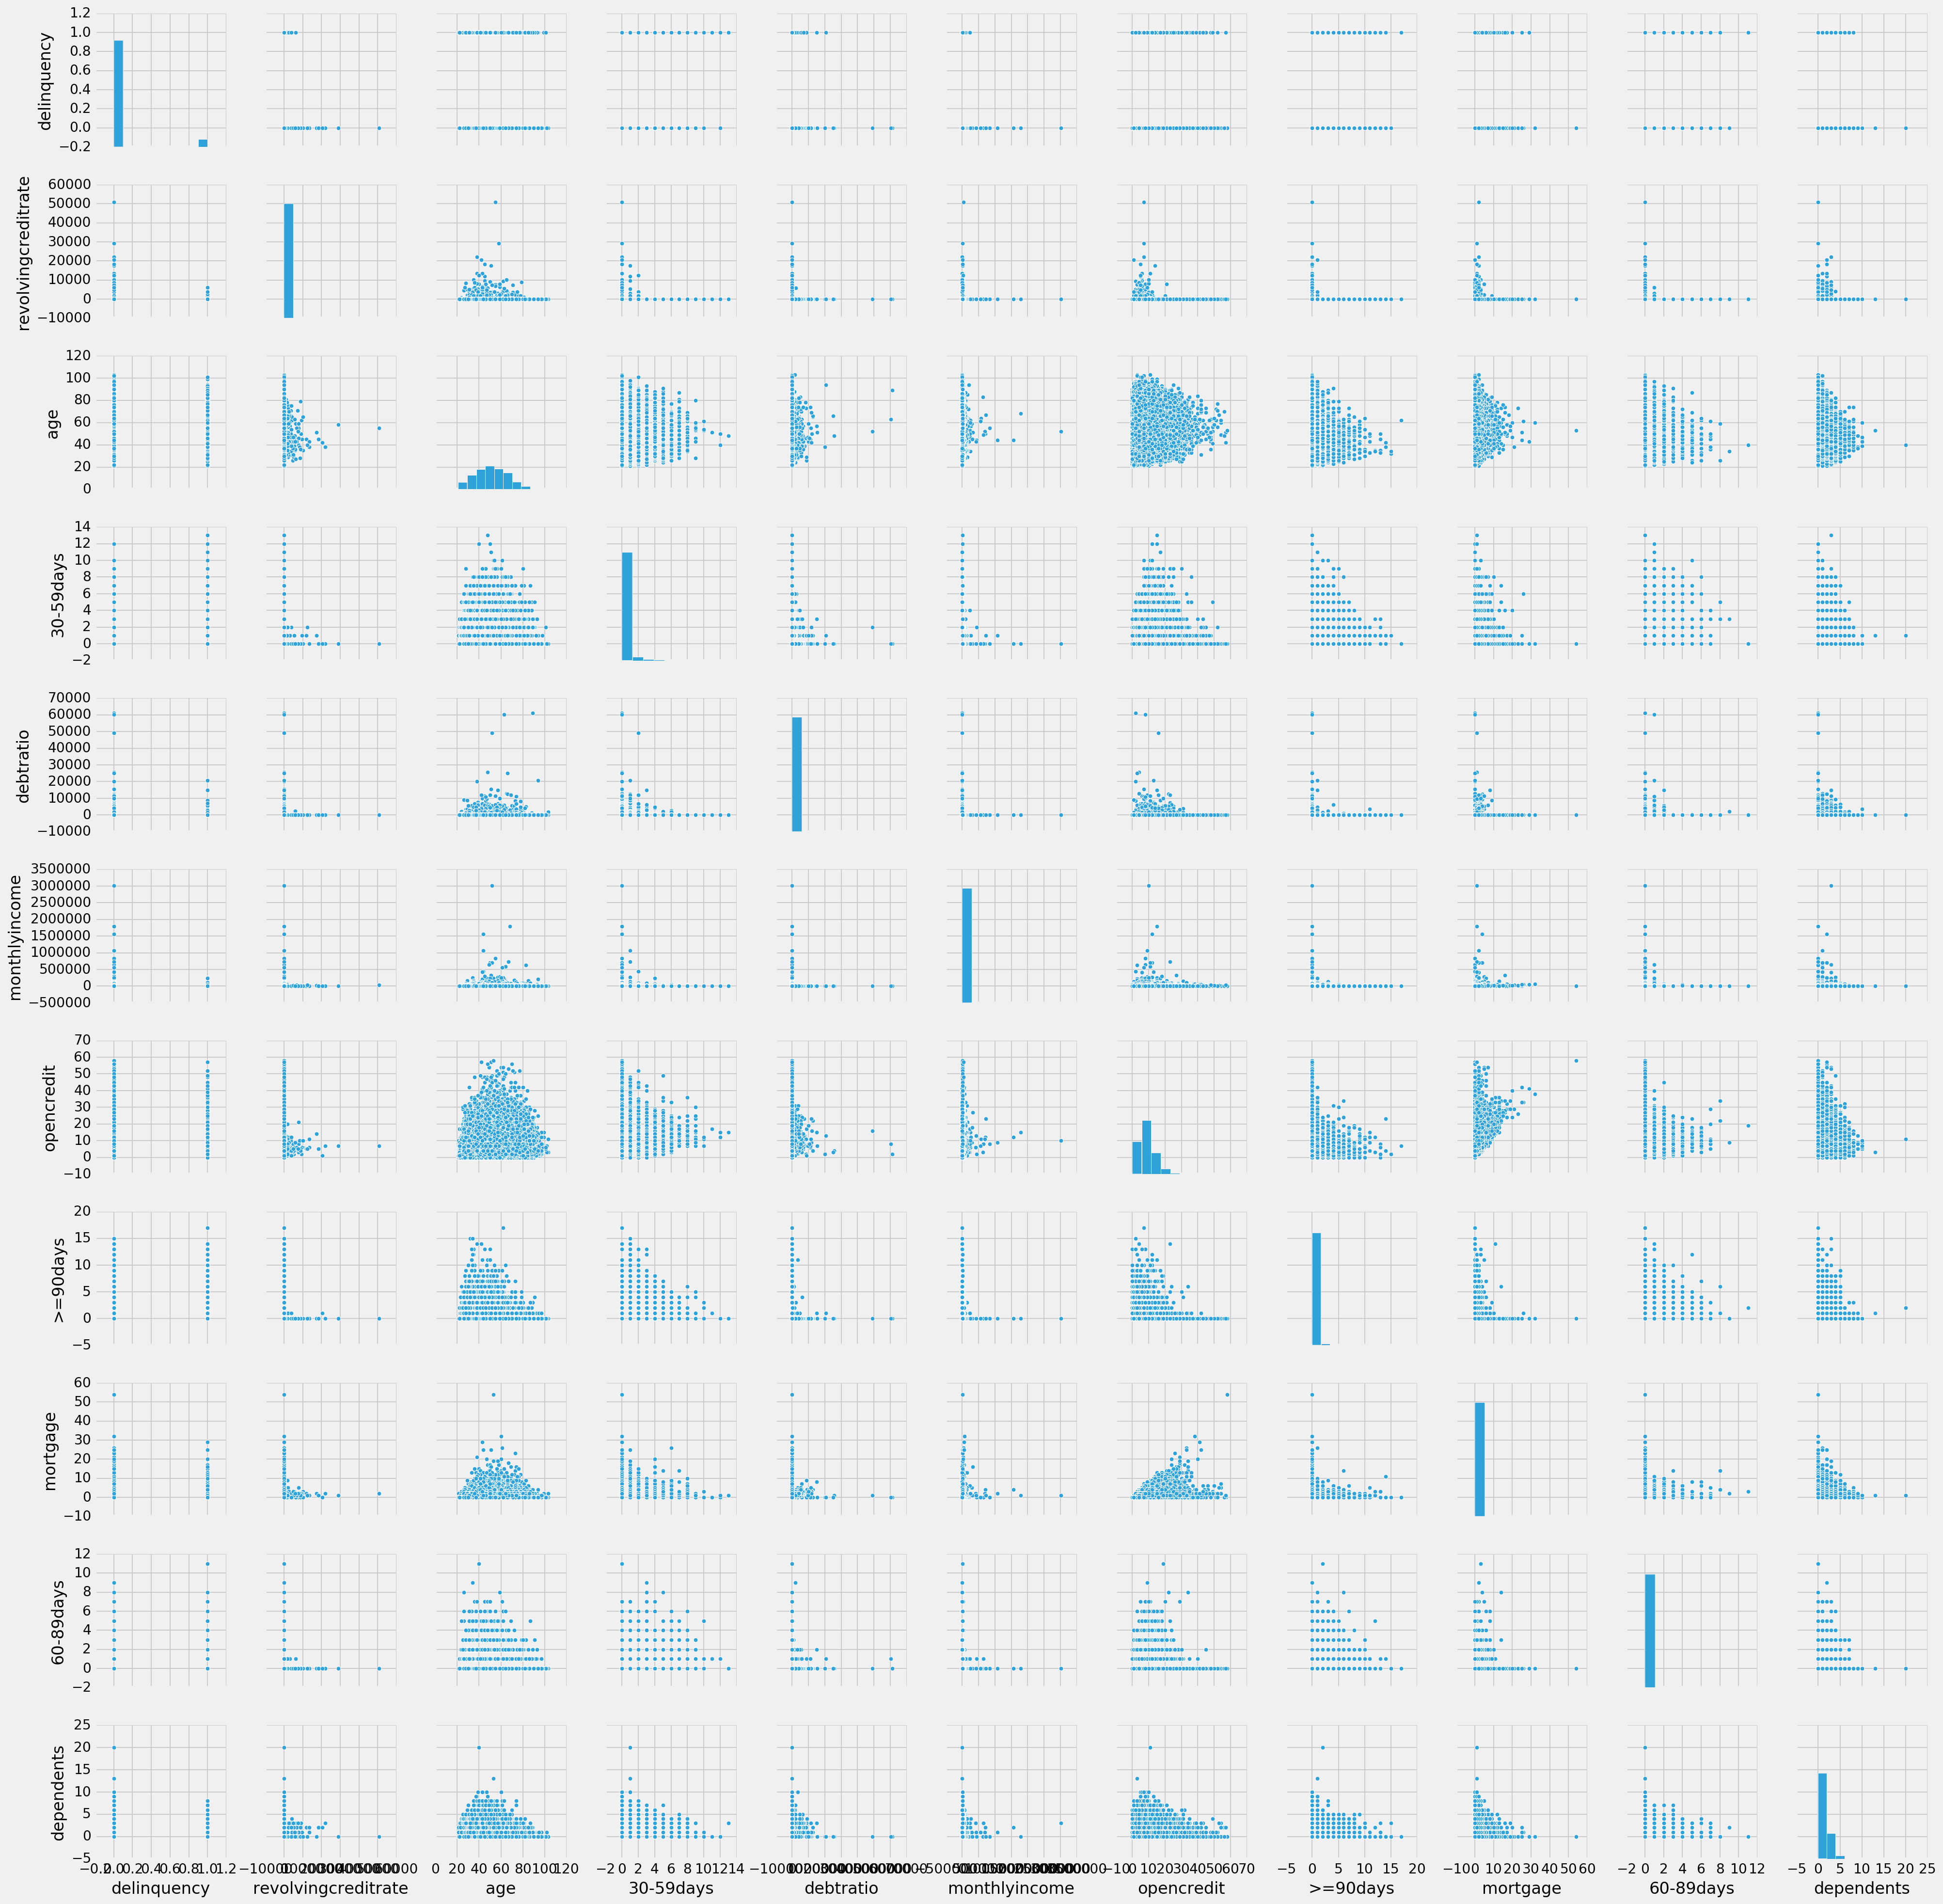

In [32]:
sns.pairplot(df)
plt.show()

> Looking at the various distributions, we can observe that mortgage, revolvingcreditrate, monthlyincome and dependents seem to have a solitary point that is a strong outlier. We shall examine these points to determine if they should be dropped.

In [254]:
df['mortgage'].max()

54

In [249]:
df.loc[df['mortgage'] == 54]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents,monthlydebt,sumnan
30588,0,0.003032,53,0,5.967504,8000.0,58,0,54,0,0.0,47740.032496,0


>This extreme outlier in our mortgage variable seems to be valid given the number of open credits is high as well.

In [255]:
df['revolvingcreditrate'].max()

50708.0

In [253]:
df.loc[df['revolvingcreditrate']==50708]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents,monthlydebt,sumnan
85490,0,50708.0,55,0,0.221757,38000.0,7,0,2,0,0.0,8426.778236,0


>This observation with a high revolving credit rate looks to be representative as well given his high monthly debt

In [256]:
df['dependents'].max()

20.0

In [257]:
df.loc[df['dependents']==20]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents,monthlydebt,sumnan
6300,0,0.226616,40,1,0.576539,6316.0,11,2,1,0,20.0,3641.423463,0


>This individual with the highest number of dependents doesn't look to be erroneous and should serve as a valid observation

In [258]:
df['monthlyincome'].max()

3008750.0

In [259]:
df.loc[df['monthlyincome']==3008750]

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents,monthlydebt,sumnan
73764,0,0.007328,52,0,0.00147,3008750.0,10,0,1,0,3.0,4422.997894,0


>While having a monthly income of 3million is insane, it is not impossible. There is nothing to say that this entry contains an error.

In [162]:
df.head()

,delinquency,revolvingcreditrate,age,30-59days,debtratio,monthlyincome,opencredit,>=90days,mortgage,60-89days,dependents,monthlydebt,sumnan
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,7323.197016,0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,316.878123,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,258.914887,0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,118.963951,0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1584.975094,0


## Preparing test set
>We preprocess the test set in the same way we did for the training set.

In [69]:
test= pd.read_csv('cs-test.csv', index_col='Unnamed: 0')

In [70]:
test.rename(columns = {'SeriousDlqin2yrs': 'delinquency', 'RevolvingUtilizationOfUnsecuredLines':'revolvingcreditrate',
                    'NumberOfTime30-59DaysPastDueNotWorse': '30-59days', 
                     'NumberOfOpenCreditLinesAndLoans':'opencredit', 'NumberOfTimes90DaysLate':'>=90days',
                    'NumberRealEstateLoansOrLines':'mortgage', 'NumberOfTime60-89DaysPastDueNotWorse':'60-89days',
                    'NumberOfDependents':'dependents'}, inplace=True)

In [71]:
test.columns=[x.lower() for x in test.columns]

In [72]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
delinquency            0 non-null float64
revolvingcreditrate    101503 non-null float64
age                    101503 non-null int64
30-59days              101503 non-null int64
debtratio              101503 non-null float64
monthlyincome          81400 non-null float64
opencredit             101503 non-null int64
>=90days               101503 non-null int64
mortgage               101503 non-null int64
60-89days              101503 non-null int64
dependents             98877 non-null float64
dtypes: float64(5), int64(6)
memory usage: 9.3 MB


In [75]:
test['monthlyincome'].fillna(1, inplace = True)
test['monthlyincome'].replace(0.0, 1, inplace=True)

In [76]:
test['monthlydebt'] = test['monthlyincome'] * test['debtratio']

In [77]:
test['monthlyincome'].replace(1, -1, inplace=True)

In [78]:
test['dependents'].fillna(-1, inplace=True)
test['sumnan'] = test.apply(lambda x: (x==-1).sum(), axis=1)

In [79]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101503 entries, 1 to 101503
Data columns (total 13 columns):
delinquency            0 non-null float64
revolvingcreditrate    101503 non-null float64
age                    101503 non-null int64
30-59days              101503 non-null int64
debtratio              101503 non-null float64
monthlyincome          101503 non-null float64
opencredit             101503 non-null int64
>=90days               101503 non-null int64
mortgage               101503 non-null int64
60-89days              101503 non-null int64
dependents             101503 non-null float64
monthlydebt            101503 non-null float64
sumnan                 101503 non-null int64
dtypes: float64(6), int64(7)
memory usage: 10.8 MB


### Preparing X and y train and test sets

In [90]:
y = df['delinquency'].values
X = df.drop(['delinquency'], axis=1)

In [80]:
X_test = test.drop(['delinquency'], axis=1)

### SMOTEENN
> We need to account for the imbalance in the classes. For that, I will be using SMOTE followed by Edited Nearest Neighbours. SMOTE oversamples the minority class followed by editing for nearest neighbors to ensure that classes are distinct.

In [56]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [171]:
os_us = SMOTEENN(k=5, size_ngh=5, random_state=123, n_jobs=-1)
X_res, y_res = os_us.fit_sample(X, y)

/Users/timmoti/anaconda/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/Users/timmoti/anaconda/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)
/Users/timmoti/anaconda/lib/python2.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


In [172]:
from collections import Counter
print 'Distribution of class labels before resampling: {}'.format(Counter(y))
print 'Distribution of class labels after resampling: {}'.format(Counter(y_res))

Distribution of class labels before resampling: Counter({0: 139974, 1: 10026})
Distribution of class labels after resampling: Counter({1: 87133, 0: 69282})


# Modeling and Evaluation
>We will be modeling our data with 3 different models. We start with Logistic Regression, followed by a random forest classifier and finally a gradient boosted classifier.

> Our evaluation criteria will be the Area under the ROC Curve metric (AUC) where we calculate the probability that our classifier will rank a randomly chosen positive example higher than a randomly chosen negative example.


### Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegressionCV

In [173]:
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=200, cv=5, random_state=123)
lr_ridge.fit(X_res, y_res)

LogisticRegressionCV(Cs=200, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [68]:
print lr_ridge.C_

[ 3292.9712551]


In [129]:
from sklearn.model_selection import cross_val_score

In [174]:
ridge_auc = cross_val_score(lr_ridge, X_res, y_res, cv=5, scoring='roc_auc')
ridge_auc

array([ 0.89138727,  0.90168558,  0.90315968,  0.90134345,  0.90625547])

In [175]:
ridge_auc.mean()

0.90076628973484996

In [176]:
yhat_ridge_pp = lr_ridge.predict_proba(X_test)
yhat_ridge_pp

array([[ 0.66882698,  0.33117302],
       [ 0.6937345 ,  0.3062655 ],
       [ 0.60002632,  0.39997368],
       ..., 
       [ 0.82812158,  0.17187842],
       [ 0.54515338,  0.45484662],
       [ 0.55563729,  0.44436271]])

### Random forest

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [192]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=123)
rfc.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [194]:
rfc_auc = cross_val_score(rfc, X_res, y_res, cv=5, scoring='roc_auc')
rfc_auc

array([ 0.97201919,  0.99877401,  0.9988838 ,  0.99890223,  0.99873814])

In [195]:
rfc_auc.mean()

0.99346347427022974

In [196]:
yhat_rfc_pp = rfc.predict_proba(X_test)
yhat_rfc_pp

array([[ 0.97,  0.03],
       [ 0.9 ,  0.1 ],
       [ 0.99,  0.01],
       ..., 
       [ 1.  ,  0.  ],
       [ 0.75,  0.25],
       [ 0.93,  0.07]])

In [134]:
#baseline
rfc_auc = cross_val_score(rfc, X_res, y_res, cv=5, scoring='roc_auc')
rfc_auc

array([ 0.92253737,  0.9971568 ,  0.99695635,  0.99664741,  0.99574766])

In [135]:
#baseline
rfc_auc.mean()

0.9818091178474061

In [146]:
#baseline
yhat_rfc_pp = rfc.predict_proba(X_test)
yhat_rfc_pp

array([[ 1. ,  0. ],
       [ 0.9,  0.1],
       [ 1. ,  0. ],
       ..., 
       [ 1. ,  0. ],
       [ 1. ,  0. ],
       [ 1. ,  0. ]])

### Gradient Boosting Classifier

In [203]:
from sklearn.ensemble import GradientBoostingClassifier

In [214]:
#Untuned
gbc = GradientBoostingClassifier(random_state=123)
gbc.fit(X_res, y_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)

In [205]:
gbc_auc = cross_val_score(gbc, X_res, y_res, cv=5, scoring='roc_auc')
gbc_auc

array([ 0.95320598,  0.99392571,  0.99367818,  0.99421086,  0.9945891 ])

In [206]:
gbc_auc.mean()

0.98592196497101769

In [207]:
yhat_gbc_pp = gbc.predict_proba(X_test)
yhat_gbc_pp

array([[ 0.73690622,  0.26309378],
       [ 0.77305049,  0.22694951],
       [ 0.97092431,  0.02907569],
       ..., 
       [ 0.97831828,  0.02168172],
       [ 0.75039192,  0.24960808],
       [ 0.8440722 ,  0.1559278 ]])

### Hyperparameter tuning of Gradient Boosted Classifier

In [215]:
from sklearn.model_selection import GridSearchCV

In [221]:
param_test1 = {'learning_rate':[0.05, 0.01, 0.005, 0.001]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 500, max_features='sqrt',random_state=123), 
                        param_grid = param_test1, n_jobs=-1,iid=False, cv=5)

In [222]:
%time gsearch1.fit(X_res, y_res)

CPU times: user 1min, sys: 2.41 s, total: 1min 2s
Wall time: 10min 19s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'learning_rate': [0.05, 0.01, 0.005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [223]:
gsearch1.best_params_, gsearch1.best_score_

({'learning_rate': 0.05}, 0.93936734701753921)

In [226]:
param_test2 = {'min_samples_split':range(2,11,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=10, max_features='sqrt', random_state=123), 
param_grid = param_test2,n_jobs=-1,iid=False, cv=5)

In [227]:
%time gsearch2.fit(X_res, y_res)

CPU times: user 1min 10s, sys: 1.11 s, total: 1min 11s
Wall time: 17min 46s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=10,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'min_samples_split': [2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [228]:
gsearch2.best_params_, gsearch2.best_score_

({'min_samples_split': 2}, 0.9417773694251782)

In [229]:
param_test3 = {'min_samples_leaf':range(2,11,2)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=10, min_samples_split=2, max_features='sqrt', random_state=123), 
param_grid = param_test3,n_jobs=-1,iid=False, cv=5)

In [230]:
%time gsearch3.fit(X_res, y_res)

CPU times: user 1min 11s, sys: 1.6 s, total: 1min 13s
Wall time: 18min 39s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=10,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [231]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 4}, 0.94133623485389517)

In [235]:
param_test4 = {'subsample':[0.6,0.7,0.8,0.9]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', random_state=123), 
param_grid = param_test4,n_jobs=-1,iid=False, cv=5)

In [236]:
%time gsearch4.fit(X_res, y_res)

CPU times: user 1min 1s, sys: 1.02 s, total: 1min 2s
Wall time: 12min 52s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=10,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [237]:
gsearch4.best_params_, gsearch4.best_score_

({'subsample': 0.8}, 0.94104853620864404)

In [238]:
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=10, min_samples_split=2, min_samples_leaf=4, subsample=0.8, max_features='sqrt', random_state=123)

In [260]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=10, min_samples_split=2, min_samples_leaf=4, subsample=0.8, max_features='sqrt', random_state=123)

In [ ]:
%time gbc.fit(X_res,y_res)

In [239]:
%time gbc.fit(X_res,y_res)

CPU times: user 7min 29s, sys: 4.58 s, total: 7min 33s
Wall time: 7min 40s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=10,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=123, subsample=0.8, verbose=0,
              warm_start=False)

In [240]:
gbc_auc = cross_val_score(gbc, X_res, y_res, cv=5, scoring='roc_auc')
gbc_auc

array([ 0.95909269,  0.9996318 ,  0.99969044,  0.99967669,  0.99963761])

In [241]:
gbc_auc.mean()

0.99154584661318579

In [242]:
yhat_gbc_pp = gbc.predict_proba(X_test)
yhat_gbc_pp

array([[ 0.95794291,  0.04205709],
       [ 0.99096037,  0.00903963],
       [ 0.98260197,  0.01739803],
       ..., 
       [ 0.99885392,  0.00114608],
       [ 0.9399368 ,  0.0600632 ],
       [ 0.96500007,  0.03499993]])

### Submission

In [243]:
#Get 2nd column of predicted probabilities for probability of delinquency happening for each observation
sub = yhat_gbc_pp[:,1]

In [244]:
#Convert into dataframe and name column as probability following submission example
subdf = pd.DataFrame(sub, columns=['probability'])

In [245]:
#Increase index of all Ids by 1 to start from 1 and not 0
subdf.index += 1

In [246]:
#Rename index column as 'Id' following submission guidelines
subdf.index.name = 'Id'
subdf.head()

,probability
Id,
1,0.042057
2,0.009040
3,0.017398
4,0.118644
5,0.152333


In [247]:
#Save as csv file for submission
subdf.to_csv('sub.csv')

# Results 

> Our best score on the private leaderboard of the Give Me Some Credit Kaggle competition is an AUC of 0.854660 from our untuned Gradient Boosting Classifier
![AUCscore](/aucscore.png). Despite tuning the hyperparameters, our tuned model didn't give a better result.